# Data

Before we build the model, we need to obtain some data for it. There's a [dataset on Kaggle](https://www.kaggle.com/mczielinski/bitcoin-historical-data) that details minute by minute Bitcoin prices (plus some other factors) for the last few years (featured on that [other blog post](http://www.jakob-aungiers.com/articles/a/Multidimensional-LSTM-Networks-to-Predict-Bitcoin-Price)). Over this timescale, noise could overwhelm the signal, so we'll opt for daily prices. The issue here is that we may have not sufficient data (we'll have hundreds of rows rather than thousands or millions). In deep learning, no model can overcome a severe lack of data. I also don't want to rely on static files, as that'll complicate the process of updating the model in the future with new data. Instead, we'll aim to pull data from websites and APIs.

As we'll be combining multiple cryptos in one model, it's probably a good idea to pull the data from one source. We'll use [coinmarketcap.com](https://coinmarketcap.com). For now, we'll only consider Bitcoin and Ether, but it wouldn't be hard to add the [latest overhyped altcoin](https://coinmarketcap.com/currencies/iota/) using this approach. Before we import the data, we must load some python packages that will make our lives so much easier.

In [4]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

# # get market info for bitcoin from the start of 2016 to the current day
# bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]

# # convert the date string to the correct date format
# bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# # when Volume is equal to '-' convert it to 0
# bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# # convert to int
# bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# # sometime after publication of the blog, coinmarketcap starting returning asterisks in the column names
# # this will remove those asterisks
# bitcoin_market_info.columns = bitcoin_market_info.columns.str.replace("*", "")
# # look at the first few rows
# bitcoin_market_info.head()

# from google.colab import drive
# drive.mount('/content/drive')


bitcoin_market_info = pd.read_csv('./BTC-USD_5Y.csv')
bitcoin_market_info


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-24,8901.950195,8996.179688,8665.700195,8668.120117,8668.120117,5664600064
1,2018-03-25,8612.809570,8682.009766,8449.099609,8495.780273,8495.780273,4569880064
2,2018-03-26,8498.469727,8530.080078,7921.430176,8209.400391,8209.400391,5921039872
3,2018-03-27,8200.000000,8232.780273,7797.279785,7833.040039,7833.040039,5378250240
4,2018-03-28,7836.830078,8122.890137,7809.169922,7954.479980,7954.479980,4935289856
...,...,...,...,...,...,...,...
1817,2023-03-15,24770.925781,25240.615234,23964.910156,24375.960938,24375.960938,43655701450
1818,2023-03-16,24373.457031,25190.326172,24225.111328,25052.789063,25052.789063,33866061747
1819,2023-03-17,25055.123047,27787.812500,24955.169922,27423.929688,27423.929688,50730261335
1820,2023-03-18,27448.117188,27725.953125,26636.261719,26965.878906,26965.878906,35723036817


## Exploratory Data Analysis (EDA)




In [5]:
# bitcoin_market_info = bitcoin_market_info[:-10]

In [6]:
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-03-24,8901.950195,8996.179688,8665.700195,8668.120117,8668.120117,5664600064
1,2018-03-25,8612.809570,8682.009766,8449.099609,8495.780273,8495.780273,4569880064
2,2018-03-26,8498.469727,8530.080078,7921.430176,8209.400391,8209.400391,5921039872
3,2018-03-27,8200.000000,8232.780273,7797.279785,7833.040039,7833.040039,5378250240
4,2018-03-28,7836.830078,8122.890137,7809.169922,7954.479980,7954.479980,4935289856


In [7]:
bitcoin_market_info.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1817,2023-03-15,24770.925781,25240.615234,23964.910156,24375.960938,24375.960938,43655701450
1818,2023-03-16,24373.457031,25190.326172,24225.111328,25052.789063,25052.789063,33866061747
1819,2023-03-17,25055.123047,27787.812500,24955.169922,27423.929688,27423.929688,50730261335
1820,2023-03-18,27448.117188,27725.953125,26636.261719,26965.878906,26965.878906,35723036817
1821,2023-03-19,26969.503906,28440.560547,26907.716797,28038.675781,28038.675781,37769448859


In [8]:
bitcoin_market_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1822 entries, 0 to 1821
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1822 non-null   object 
 1   Open       1822 non-null   float64
 2   High       1822 non-null   float64
 3   Low        1822 non-null   float64
 4   Close      1822 non-null   float64
 5   Adj Close  1822 non-null   float64
 6   Volume     1822 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 99.8+ KB


In [9]:
bitcoin_market_info.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1822.000000,1822.000000,1822.000000,1822.000000,1822.000000,1.822000e+03
mean,20834.139434,21337.196838,20280.288949,20842.240267,20842.240267,2.732461e+10
std,16888.255071,17334.309102,16368.243288,16882.160969,16882.160969,1.958294e+10
min,3236.274658,3275.377930,3191.303467,3236.761719,3236.761719,2.923670e+09
25%,7695.299317,7908.665893,7527.278565,7693.000610,7693.000610,1.474684e+10
50%,11679.506347,11899.835449,11335.738282,11696.665527,11696.665527,2.524440e+10
75%,33843.626953,34826.715820,32306.704590,33785.009766,33785.009766,3.614411e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


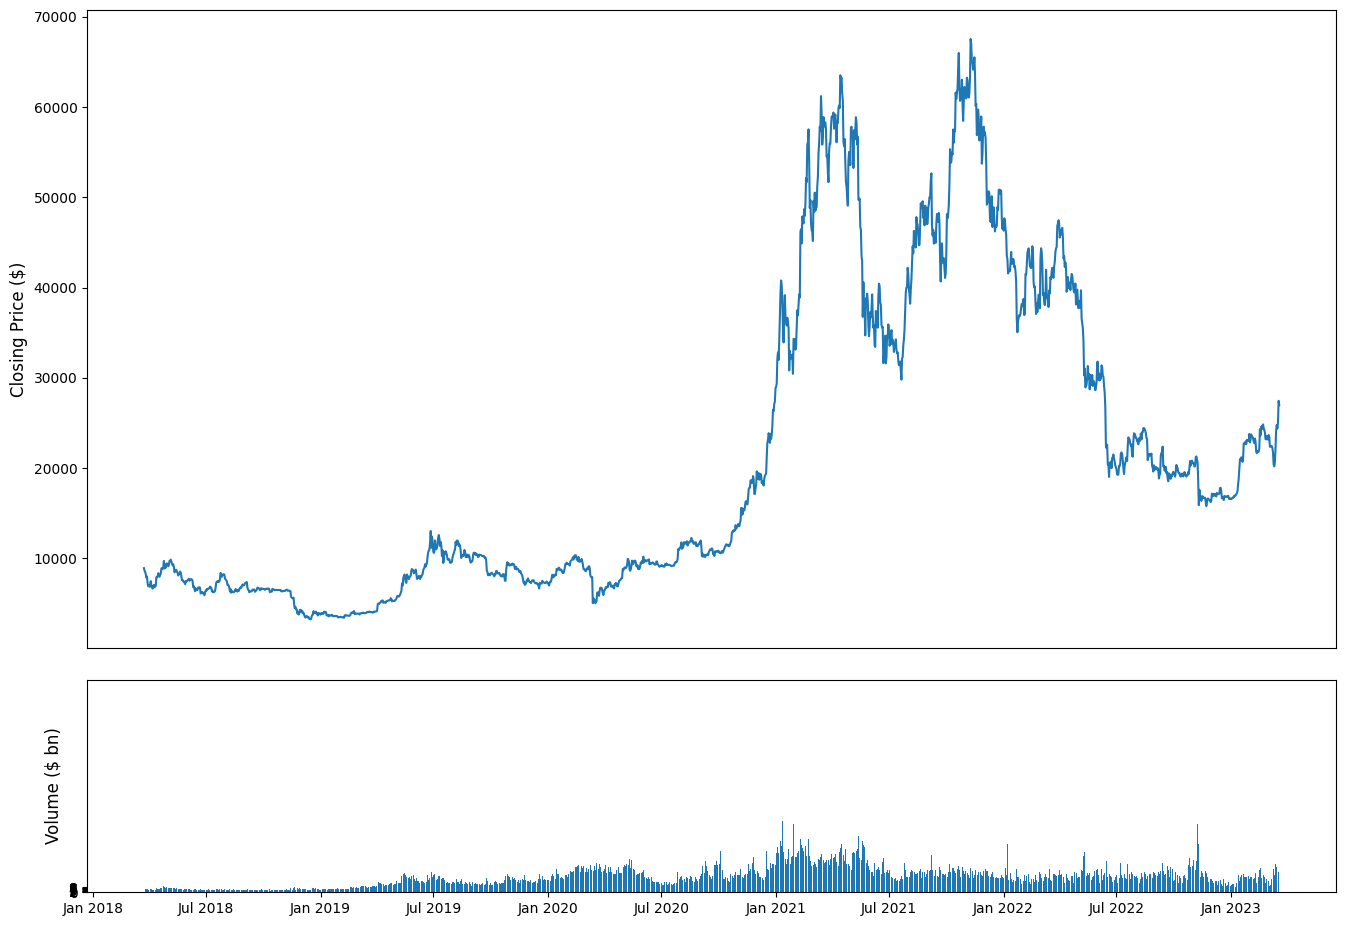

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2018,2024) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2018,2024) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2018,2024) for j in [1,7]])
ax1.plot(bitcoin_market_info['Date'],bitcoin_market_info['Open'])
ax2.bar(bitcoin_market_info['Date'].values, bitcoin_market_info['Volume'].values)
fig.tight_layout()
fig.set_size_inches(15, 10)

plt.show()

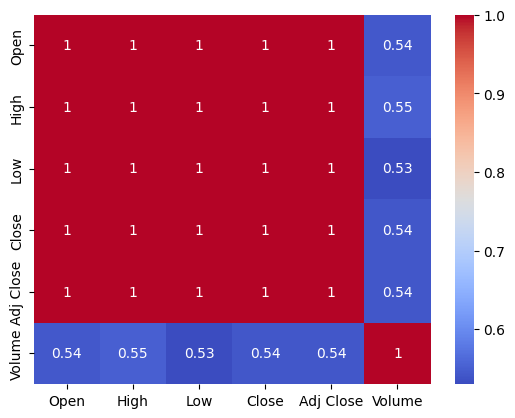

In [11]:
# tạo ma trận tương quan
corr = bitcoin_market_info.corr()

# vẽ heatmap cho ma trận tương quan
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [12]:
corr_matrix = bitcoin_market_info[['Adj Close', 'Open', 'High', 'Low', 'Volume']].corr()
print(corr_matrix)

           Adj Close      Open      High       Low    Volume
Adj Close   1.000000  0.998207  0.999203  0.999080  0.542015
Open        0.998207  1.000000  0.999286  0.998693  0.544231
High        0.999203  0.999286  1.000000  0.998571  0.551473
Low         0.999080  0.998693  0.998571  1.000000  0.529830
Volume      0.542015  0.544231  0.551473  0.529830  1.000000


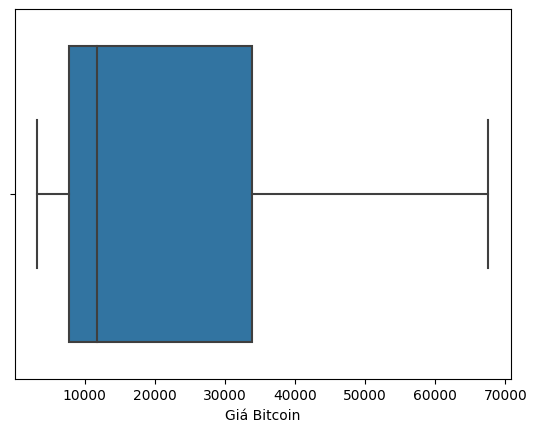

In [13]:
# vẽ box plot cho giá Bitcoin
sns.boxplot(x=bitcoin_market_info['Adj Close'])
plt.xlabel('Giá Bitcoin')
plt.show()

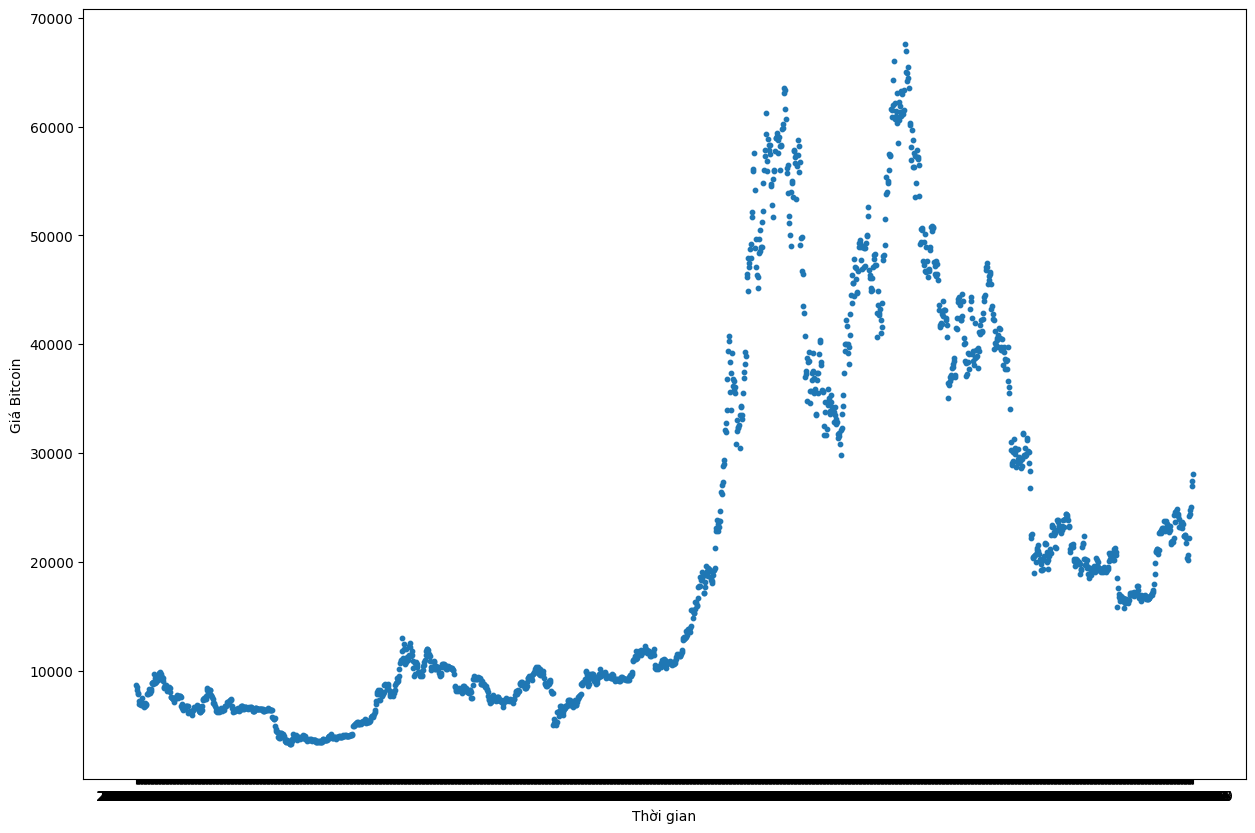

In [14]:
# vẽ scatter plot giữa giá Bitcoin và thời gian
fig = plt.figure(figsize=(15,10))
plt.scatter(bitcoin_market_info['Date'], bitcoin_market_info['Adj Close'], s = 10)
plt.xlabel('Thời gian')
plt.ylabel('Giá Bitcoin')
plt.show()


Check Null

In [15]:
print('Null Values:',bitcoin_market_info.isnull().values.sum())

Null Values: 0


In [16]:
print('NA values:',bitcoin_market_info.isnull().values.any())

NA values: False


In [17]:
bitcoin_market_info=bitcoin_market_info.dropna()
print('Null Values:',bitcoin_market_info.isnull().values.sum())
print('NA values:',bitcoin_market_info.isnull().values.any())

Null Values: 0
NA values: False


In [18]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]


`day_diff` để tính toán sự khác biệt giá giữa giá đóng cửa và giá mở cửa của mỗi ngày trong dữ liệu Bitcoin

In [19]:
market_info = bitcoin_market_info
market_info = market_info[market_info['Date']>='2020-03-14']
for coins in ['bt_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Adj Close,bt_Volume,bt_day_diff
721,2020-03-14,5573.077637,5625.226563,5125.069336,5200.366211,5200.366211,36154506008,-0.066877
722,2020-03-15,5201.066895,5836.645020,5169.283203,5392.314941,5392.314941,33997889639,0.036771
723,2020-03-16,5385.229492,5385.229492,4575.357910,5014.479980,5014.479980,45368026430,-0.068846
724,2020-03-17,5002.578125,5371.348633,4981.909180,5225.629395,5225.629395,38622642935,0.044587
725,2020-03-18,5227.113770,5331.833984,5069.335938,5238.438477,5238.438477,37878801016,0.002167


In [20]:
split_date = '2022-05-01'

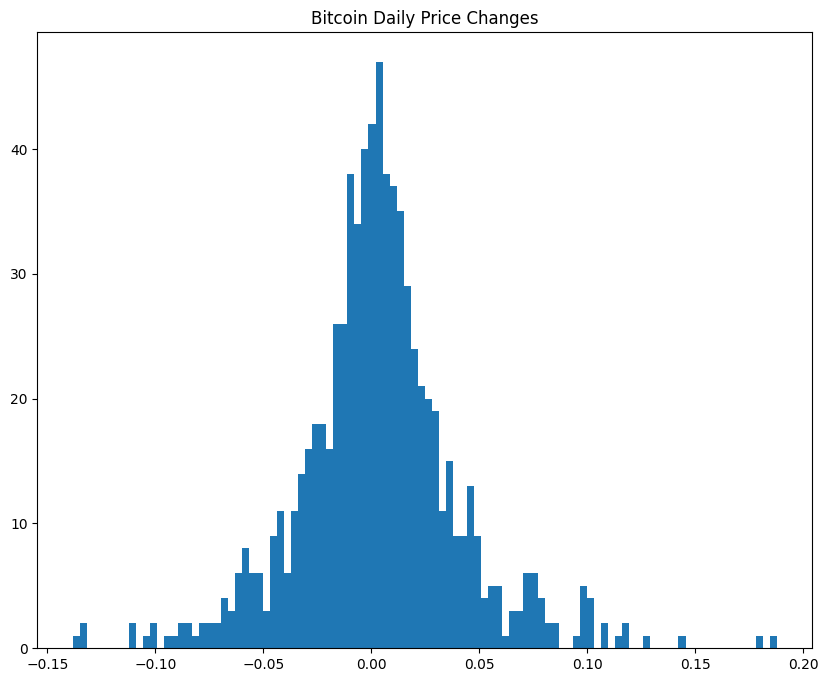

In [21]:
fig, (ax1) = plt.subplots(1,1)
ax1.hist(market_info[market_info['Date']< split_date]['bt_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')
fig.set_size_inches(10,8)
plt.show()

Chuyển Date sang datetime

In [22]:
bitcoin_market_info['Date'] = pd.to_datetime(bitcoin_market_info['Date'])

Chia train và test theo ngày 

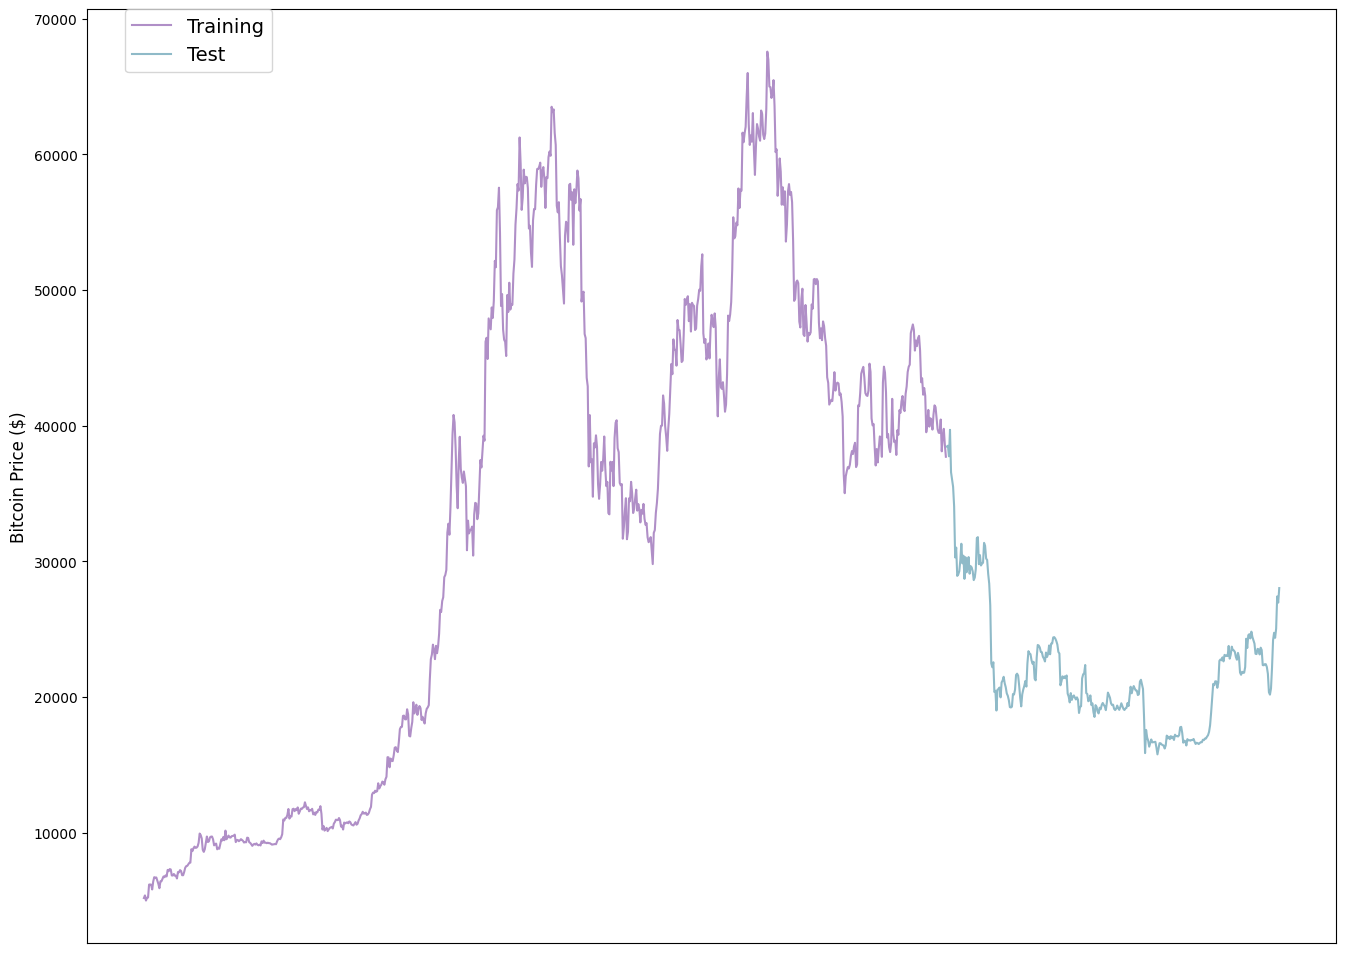

In [23]:
# split_date = '2022-05-01'
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2018,2024) for j in [1,7]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2018,2024) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'],
         market_info[market_info['Date'] < split_date]['bt_Close'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'],
         market_info[market_info['Date'] >= split_date]['bt_Close'], 
         color='#8FBAC8', label='Test')

ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
fig.set_size_inches(15, 10)

plt.show()

In [24]:
len(market_info[market_info['Date'] >= split_date]['Date'])/len(market_info['Date'])

0.29336966394187103

# Long Short Term Memory (LSTM)

Like I said, if you're interested in the theory behind LSTMs, then I'll refer you to [this](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), [this](http://blog.echen.me/2017/05/30/exploring-lstms/) and [this](http://www.bioinf.jku.at/publications/older/2604.pdf). Luckily, we don't need to build the network from scratch (or even understand it), there exists packages that include standard implementations of various deep learning algorithms (e.g. [TensorFlow](https://www.tensorflow.org/get_started/get_started), [Keras](https://keras.io/#keras-the-python-deep-learning-library), [PyTorch](http://pytorch.org/), etc.). I'll opt for Keras, as I find it the most intuitive for non-experts. If you're not familiar with Keras, then check out my [previous tutorial](https://dashee87.github.io/data%20science/deep%20learning/python/another-keras-tutorial-for-neural-network-beginners/).

`close_off_high` represents the gap between the closing price and price high for that day, where values of -1 and 1 mean the closing price was equal to the daily low or daily high, respectively. The `volatility` columns are simply the difference between high and low price divided by the opening price. You may also notice that model_data is arranged in order of earliest to latest. We don't actually need the date column anymore, as that information won't be fed into the model.

Our LSTM model will use previous data (both bitcoin and eth) to predict the next day's closing price of a specific coin. We must decide how many previous days it will have access to. Again, it's rather arbitrary, but I'll opt for 10 days, as it's a nice round number. We build little data frames consisting of 10 consecutive days of data (called windows), so the first window will consist of the 0-9th rows of the training set (Python is zero-indexed), the second will be the rows 1-10, etc. Picking a small window size means we can feed more windows into our model; the downside is that the model may not have sufficient information to detect complex long term behaviours (if such things exist).

In [25]:
for coins in ['bt_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

`close_off_high` là một biến được định nghĩa để tính toán chỉ số dựa trên giá đóng cửa và giá cao nhất của một loại tiền điện tử (được đại diện bởi biến coins).

Cụ thể, `close_off_high` được tính bằng công thức: 
`2*(x[coins+'High'] - x[coins+'Close']) / (x[coins+'High'] - x[coins+'Low']) - 1`

Trong đó:
`x[coins+'High']` là giá cao nhất của tiền điện tử trong khoảng thời gian đó.
`x[coins+'Close']` là giá đóng cửa của tiền điện tử trong khoảng thời gian đó.
`x[coins+'Low']` là giá thấp nhất của tiền điện tử trong khoảng thời gian đó.

***Công thức này tính toán độ chênh lệch giữa giá đóng cửa và giá cao nhất của tiền điện tử trong khoảng thời gian đó, được chuẩn hóa trên một khoảng giá từ -1 đến 1. Nếu chỉ số này bằng 1, có nghĩa là giá đóng cửa bằng giá cao nhất, trong khi nếu chỉ số này bằng -1 thì giá đóng cửa bằng giá thấp nhất.***

Tóm lại, `close_off_high` ở đây là một chỉ số dùng để đo độ chênh lệch giữa giá đóng cửa và giá cao nhất của một loại tiền điện tử trong khoảng thời gian đó.

`volatility` là một biến được định nghĩa để tính toán độ biến động của một loại tiền điện tử trong khoảng thời gian đó.

Cụ thể, `volatility` được tính bằng công thức:
`(x[coins+'High'] - x[coins+'Low']) / (x[coins+'Open'])`

Trong đó:

`x[coins+'High']` là giá cao nhất của tiền điện tử trong khoảng thời gian đó.
`x[coins+'Low']` là giá thấp nhất của tiền điện tử trong khoảng thời gian đó.
`x[coins+'Open']` là giá mở cửa của tiền điện tử trong khoảng thời gian đó.

***Công thức này tính toán độ chênh lệch giữa giá cao nhất và giá thấp nhất của tiền điện tử trong khoảng thời gian đó, được chuẩn hóa trên giá mở cửa. Chỉ số này càng cao thì độ biến động của tiền điện tử càng lớn, và ngược lại.***

Tóm lại, `volatility` ở đây là một chỉ số dùng để đo độ biến động của một loại tiền điện tử trong khoảng thời gian đó.

In [26]:
model_data = market_info[['Date']+[coin+metric for coin in ['bt_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility
721,2020-03-14,5200.366211,36154506008,0.698907,0.089745
722,2020-03-15,5392.314941,33997889639,0.331602,0.128312
723,2020-03-16,5014.479980,45368026430,-0.084424,0.150388
724,2020-03-17,5225.629395,38622642935,-0.251646,0.077848
725,2020-03-18,5238.438477,37878801016,-0.288410,0.050219


In [27]:
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set_non = training_set
test_set_non = test_set
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_11652\4180039484.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  training_set = training_set.drop('Date', 1)
C:\Users\Admin\AppData\Local\Temp\ipykernel_11652\4180039484.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test_set = test_set.drop('Date', 1)


In [28]:
training_set

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility
721,5200.366211,36154506008,0.698907,0.089745
722,5392.314941,33997889639,0.331602,0.128312
723,5014.479980,45368026430,-0.084424,0.150388
724,5225.629395,38622642935,-0.251646,0.077848
725,5238.438477,37878801016,-0.288410,0.050219
...,...,...,...,...
1494,38117.460938,34569088416,0.835642,0.069939
1495,39241.121094,30981015184,-0.776101,0.036742
1496,39773.828125,33903704907,-0.253583,0.033843
1497,38609.824219,30882994649,0.546793,0.041534


In [29]:
test_set

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility
1499,38469.093750,27002760110,-0.695288,0.027631
1500,38529.328125,32922642426,0.188237,0.023872
1501,37750.453125,27326943244,0.684343,0.027107
1502,39698.371094,36754404490,-0.811526,0.057510
1503,36575.140625,43106256317,0.634545,0.099073
...,...,...,...,...
1817,24375.960938,43655701450,0.355571,0.051500
1818,25052.789063,33866061747,-0.715012,0.039601
1819,27423.929688,50730261335,-0.743079,0.113056
1820,26965.878906,35723036817,0.395027,0.039700


Mô hình LSTM của chúng tôi sẽ sử dụng dữ liệu trước đó để dự đoán giá đóng cửa vào ngày hôm sau của một đồng tiền cụ thể (Bitcoin). Chúng tôi phải quyết định nó sẽ có quyền truy cập vào bao nhiêu ngày trước đó. Ở đây tôi sẽ chọn 10 ngày. Chúng tôi xây dựng các khung dữ liệu nhỏ bao gồm 10 ngày dữ liệu liên tiếp (được gọi là `window_len`), vì vậy cửa sổ đầu tiên sẽ bao gồm các hàng thứ 0-9 của tập huấn luyện, cửa sổ thứ hai sẽ là các hàng 1-10 , v.v. Chọn kích thước cửa sổ nhỏ có nghĩa là chúng ta có thể đưa nhiều cửa sổ hơn vào mô hình của mình; nhược điểm là mô hình có thể không có đủ thông tin để phát hiện các hành vi dài hạn phức tạp (nếu những điều đó tồn tại).

In [30]:
window_len = 30
norm_cols = [coin+metric for coin in ['bt_'] for metric in ['Close','Volume']]

In [31]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1

In [32]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['bt_Close'][window_len:].values/test_set['bt_Close'][:-window_len].values)-1

In [33]:
LSTM_training_inputs[0]

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility
721,0.000000,0.000000,0.698907,0.089745
722,0.036911,-0.059650,0.331602,0.128312
723,-0.035745,0.254837,-0.084424,0.150388
724,0.004858,0.068266,-0.251646,0.077848
725,0.007321,0.047692,-0.288410,0.050219
726,0.190530,0.410633,-0.746436,0.208328
727,0.191989,0.505842,0.319359,0.158032
728,0.189352,0.175355,-0.132883,0.071749
729,0.121124,0.109119,0.975592,0.086651
730,0.233820,0.285923,-0.916168,0.112997


In [34]:
LSTM_training_inputs[1]

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility
722,0.000000,0.000000,0.331602,0.128312
723,-0.070069,0.334437,-0.084424,0.150388
724,-0.030912,0.136031,-0.251646,0.077848
725,-0.028536,0.114152,-0.288410,0.050219
726,0.148151,0.500115,-0.746436,0.208328
727,0.149558,0.601363,0.319359,0.158032
728,0.147015,0.249913,-0.132883,0.071749
729,0.081216,0.179475,0.975592,0.086651
730,0.189900,0.367494,-0.916168,0.112997
731,0.248963,0.418380,-0.713093,0.058720


In [35]:
LSTM_training_outputs[0]

0.3162606863188082

In [36]:
LSTM_test_inputs[0]

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility
1499,0.000000,0.000000,-0.695288,0.027631
1500,0.001566,0.219232,0.188237,0.023872
1501,-0.018681,0.012006,0.684343,0.027107
1502,0.031955,0.361135,-0.811526,0.057510
1503,-0.049233,0.596365,0.634545,0.099073
1504,-0.063120,0.399693,0.021579,0.031231
1505,-0.077131,-0.097281,0.056214,0.032992
1506,-0.114633,0.361455,0.777951,0.045742
1507,-0.212434,1.346260,1.000000,0.115241
1508,-0.193563,1.214997,0.186799,0.087585


In [37]:
LSTM_test_inputs[1]

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility
1500,0.000000,0.000000,0.188237,0.023872
1501,-0.020215,-0.169965,0.684343,0.027107
1502,0.030342,0.116387,-0.811526,0.057510
1503,-0.050719,0.309319,0.634545,0.099073
1504,-0.064585,0.148012,0.021579,0.031231
1505,-0.078573,-0.259601,0.056214,0.032992
1506,-0.116017,0.116649,0.777951,0.045742
1507,-0.213665,0.924375,1.000000,0.115241
1508,-0.194824,0.816714,0.186799,0.087585
1509,-0.248978,1.138007,0.601382,0.123903


In [38]:
LSTM_test_outputs[0]

-0.1735622691397558

Bảng này đại diện cho một ví dụ về đầu vào của mô hình LSTM của chúng ta (thực tế chúng tôi sẽ có hàng trăm bảng tương tự). Chúng tôi đã chuẩn hóa một số cột để giá trị của chúng bằng 0 tại điểm thời gian đầu tiên, vì vậy chúng tôi đang cố gắng dự đoán sự thay đổi giá so với điểm thời gian này.

Build model

In [39]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [40]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

So, the `build_model` functions constructs an empty model unimaginatively called model (`model = Sequential`), to which an LSTM layer is added. That layer has been shaped to fit our inputs (n x m tables, where n and m represent the number of timepoints/rows and columns, respectively). The function also includes more generic neural network features, like [dropout](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/) and [activation functions](https://dashee87.github.io/data%20science/deep%20learning/visualising-activation-functions-in-neural-networks/). Now, we just need to specify the number of neurons to place in the LSTM layer (I've opted for 20 to keep runtime reasonable), as well as the data on which the model will be trained.

If everything went to plan, then we'd expect the training error to have gradually decreased over time.

We shouldn't be too surprised by its apparent accuracy here. The model could access the source of its error and adjust itself accordingly. In fact, it's not hard to attain almost zero training errors. We could just cram in hundreds of neurons and train for thousands of epochs (a process known as overfitting, where you're essentially predicting noise- I included the `Dropout()` call in the `build_model` function to mitigate this risk for our relatively small model). We should be more interested in its performance on the test dataset, as this represents completely new data for the model.

In [41]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs, 
                            (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)
# #eth_model.save('eth_model%d.h5'%j)

Epoch 1/50
748/748 - 6s - loss: 0.0833 - 6s/epoch - 8ms/step
Epoch 2/50
748/748 - 3s - loss: 0.0599 - 3s/epoch - 4ms/step
Epoch 3/50
748/748 - 4s - loss: 0.0525 - 4s/epoch - 5ms/step
Epoch 4/50
748/748 - 4s - loss: 0.0496 - 4s/epoch - 5ms/step
Epoch 5/50
748/748 - 4s - loss: 0.0481 - 4s/epoch - 5ms/step
Epoch 6/50
748/748 - 4s - loss: 0.0459 - 4s/epoch - 5ms/step
Epoch 7/50
748/748 - 4s - loss: 0.0449 - 4s/epoch - 6ms/step
Epoch 8/50
748/748 - 4s - loss: 0.0447 - 4s/epoch - 5ms/step
Epoch 9/50
748/748 - 4s - loss: 0.0430 - 4s/epoch - 5ms/step
Epoch 10/50
748/748 - 4s - loss: 0.0432 - 4s/epoch - 5ms/step
Epoch 11/50
748/748 - 4s - loss: 0.0415 - 4s/epoch - 5ms/step
Epoch 12/50
748/748 - 4s - loss: 0.0422 - 4s/epoch - 5ms/step
Epoch 13/50
748/748 - 3s - loss: 0.0414 - 3s/epoch - 5ms/step
Epoch 14/50
748/748 - 3s - loss: 0.0414 - 3s/epoch - 5ms/step
Epoch 15/50
748/748 - 4s - loss: 0.0417 - 4s/epoch - 5ms/step
Epoch 16/50
748/748 - 4s - loss: 0.0422 - 4s/epoch - 5ms/step
Epoch 17/50
748/7

In [42]:
bt_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                2000      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 2,021
Trainable params: 2,021
Non-trainable params: 0
_________________________________________________________________


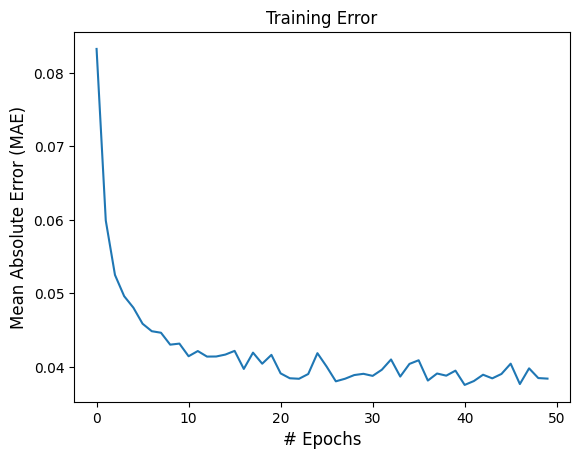

In [43]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(bt_history.epoch, bt_history.history['loss'])
ax1.set_title('Training Error')

if bt_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

In [44]:
# datetime.date(2021, 8, 1).astype()

24/24 [==============================] - 0s 2ms/step


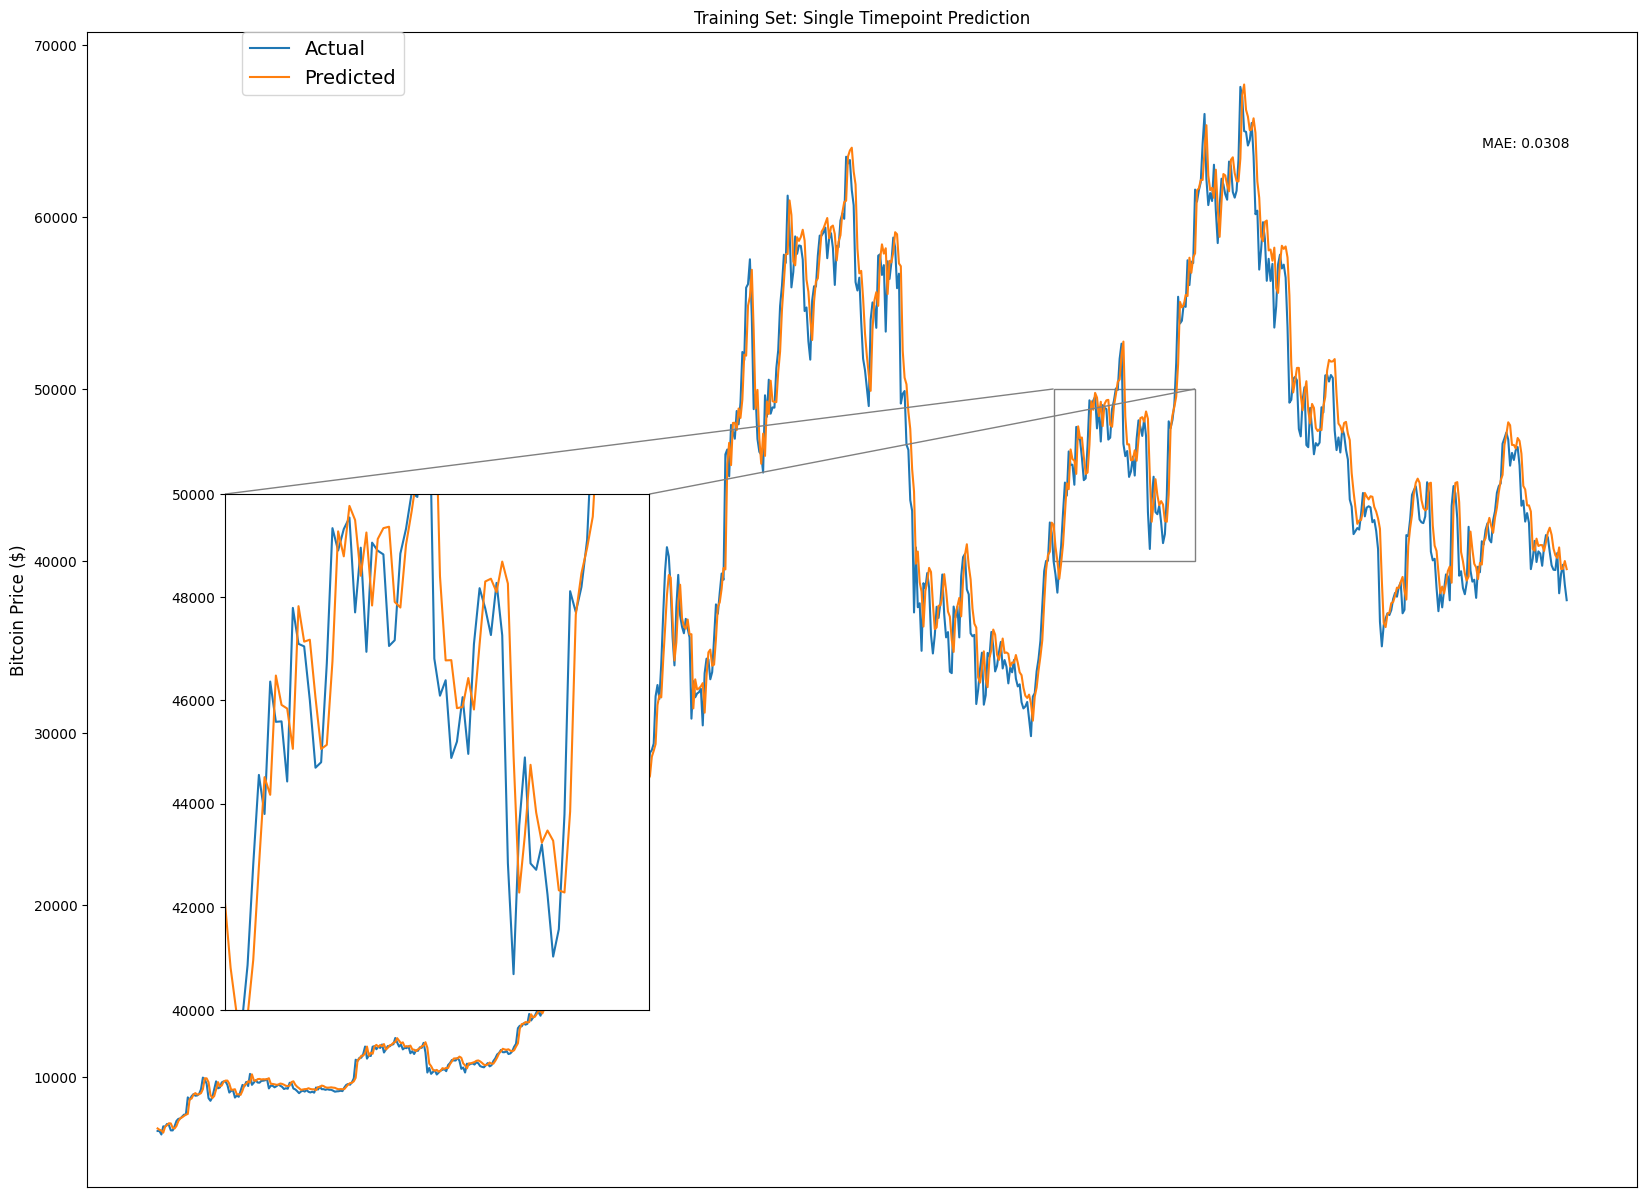

In [45]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2018,2024) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2018,2024) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         training_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_Close'].values[window_len:])/(training_set['bt_Close'].values[:-window_len]))), 
             xy=(0.9, 0.9),  xycoords='axes fraction',
            xytext=(0.9, 0.9), textcoords='axes fraction')
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 3, loc=10, bbox_to_anchor=(600, 600)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2018,2024) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         training_set['bt_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:],
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2021,8,1).strftime('%Y-%m-%d'), datetime.date(2021,10,15).strftime('%Y-%m-%d')])
axins.set_ylim([40000, 50000])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=2, loc2=1, fc="none", ec="0.5")
fig.set_size_inches(20, 15)

plt.show()

10/10 [==============================] - 0s 2ms/step


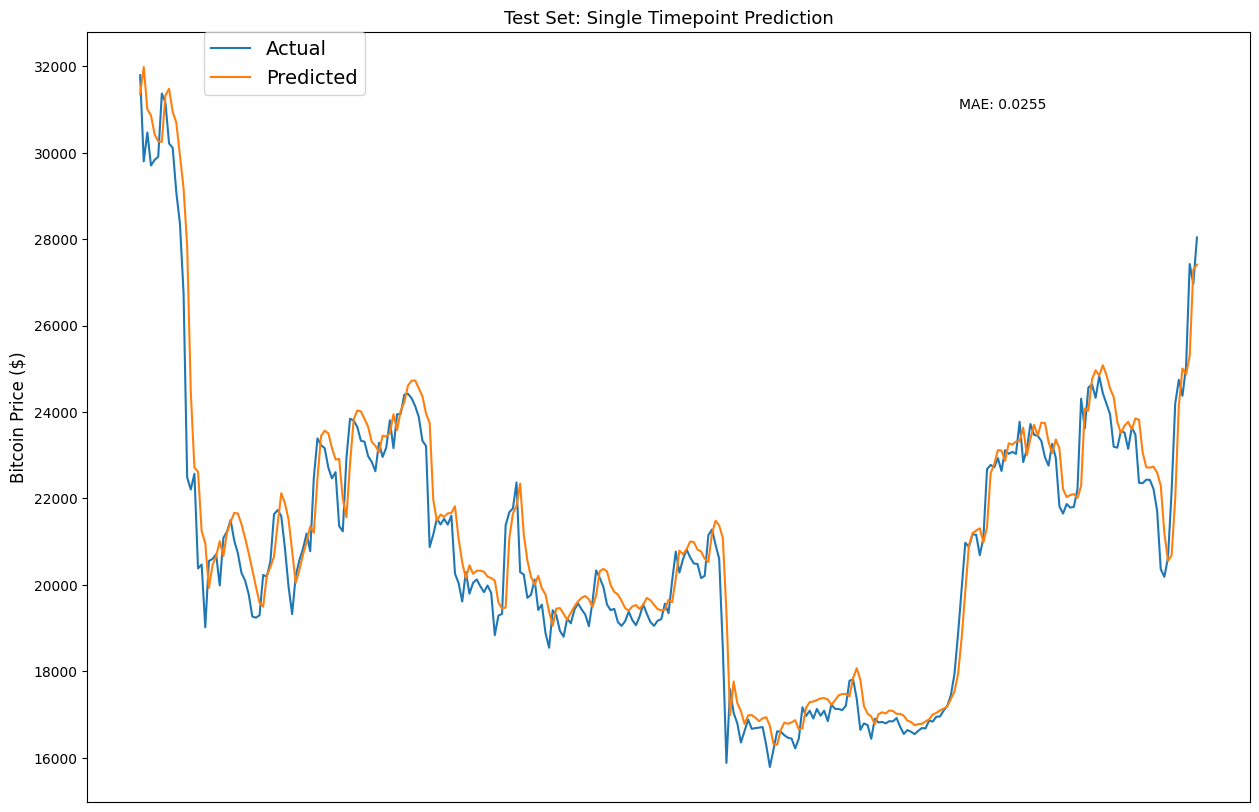

In [46]:
fig, ax1 = plt.subplots(1,1)
# ax1.set_xticks([datetime.date(2022,i+1,1) for i in range(12)])
# ax1.set_xticklabels([datetime.date(2022,i+1,1).strftime('%b %d %Y')  for i in range(12)])

# Tạo danh sách các tháng từ năm 2022 cho đến hiện tại
start_date = datetime.date(2022, 1, 1)  # Ngày bắt đầu là ngày 1 tháng 1 năm 2022
end_date = datetime.date.today()  # Ngày hiện tại
months = []
while start_date <= end_date:
    months.append(start_date)
    start_date = start_date.replace(day=1) + datetime.timedelta(days=32)
    start_date = start_date.replace(day=1)
# # Đặt các tick mark trên trục x
ax1.set_xticks([month for month in months])
ax1.set_xticklabels([month.strftime('%b %Y') for month in months])

ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:],
         test_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:],
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_Close'].values[window_len:])/(test_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
fig.set_size_inches(15, 10)

plt.show()

In [47]:
a = pd.DataFrame(((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_Close'].values[:-window_len])[0])
b = test_set['bt_Close'][window_len:]
b = b.reset_index(drop=True)
c = pd.concat([a,b], axis=1)
c = c.rename(columns={0: 'Predicted','bt_Close': 'Acutal'})
c['Range'] = c['Predicted']- c['Acutal']
c[:20]

10/10 [==============================] - 0s 2ms/step


,Predicted,Acutal,Range
0,31353.742107,31792.310547,-438.568440
1,31983.032219,29799.080078,2183.952141
2,31001.824655,30467.488281,534.336374
3,30862.844163,29704.390625,1158.453538
4,30427.724986,29832.914063,594.810923
5,30263.067420,29906.662109,356.405311
6,30250.254078,31370.671875,-1120.417797
7,31329.303551,31155.478516,173.825035
8,31479.337130,30214.355469,1264.981661
9,30948.888254,30111.998047,836.890207


Dự đoán 1 ngày 

In [48]:
result_1_day = bt_model(LSTM_test_inputs)
result_1_day

<tf.Tensor: shape=(293, 1), dtype=float32, numpy=
array([[-1.84962809e-01],
       [-1.69904247e-01],
       [-1.78769469e-01],
       [-2.22566456e-01],
       [-1.68076336e-01],
       [-1.60313696e-01],
       [-1.47927061e-01],
       [-8.01532716e-02],
       [ 3.90265062e-02],
       [-2.38592923e-03],
       [ 6.07432202e-02],
       [ 3.07249762e-02],
       [-3.46589088e-03],
       [-7.51209706e-02],
       [-2.18606234e-01],
       [-2.39484131e-01],
       [-2.56532848e-01],
       [-2.60202289e-01],
       [-3.08382273e-01],
       [-3.17499399e-01],
       [-3.04891884e-01],
       [-3.18535894e-01],
       [-2.77958930e-01],
       [-3.03065240e-01],
       [-2.82680809e-01],
       [-2.66784906e-01],
       [-2.43246973e-01],
       [-2.48529673e-01],
       [-2.73001522e-01],
       [-3.35309863e-01],
       [-3.47759694e-01],
       [-3.17099243e-01],
       [-3.44923735e-01],
       [-3.40471447e-01],
       [-3.46406639e-01],
       [-3.24357957e-01],
       [-3.491

In [49]:
len(result_1_day)

293

In [50]:
# đưa kết quả dự đoán về giá trị ban đầu của Bitcoin
predicted_prices_denormalized = []
for i in range(len(result_1_day)):
    denormalized_price = (result_1_day[i]+1) * test_set['bt_Close'].values[i] 
    predicted_prices_denormalized.append(denormalized_price)
predicted_prices_1 = np.array(predicted_prices_denormalized)
predicted_prices_1

array([[31353.742],
       [31983.031],
       [31001.824],
       [30862.844],
       [30427.725],
       [30263.068],
       [30250.254],
       [31329.303],
       [31479.338],
       [30948.889],
       [30694.043],
       [29940.244],
       [29181.611],
       [27840.03 ],
       [24461.621],
       [22711.223],
       [22620.625],
       [21247.191],
       [20965.932],
       [19929.523],
       [20458.58 ],
       [20664.527],
       [21010.607],
       [20668.008],
       [21205.648],
       [21459.17 ],
       [21664.004],
       [21653.543],
       [21407.166],
       [21088.219],
       [20736.225],
       [20349.814],
       [19958.53 ],
       [19590.895],
       [19498.594],
       [20206.197],
       [20417.186],
       [20655.678],
       [21412.69 ],
       [22119.957],
       [21893.422],
       [21519.402],
       [20786.803],
       [20048.672],
       [20348.424],
       [20698.334],
       [20990.71 ],
       [21354.307],
       [21207.104],
       [22466.799],


In [51]:
len(predicted_prices_1)

293

In [52]:
LSTM_test_outputs

array([-0.17356227, -0.22658708, -0.19292391, -0.25174787, -0.18433905,
       -0.17020263, -0.11636772, -0.08525689, -0.00272627, -0.02936244,
        0.00509564, -0.02364869, -0.08607199, -0.25294209, -0.29063368,
       -0.24411808, -0.33012076, -0.28721139, -0.37265181, -0.29613868,
       -0.30010266, -0.31701665, -0.31313478, -0.28897453, -0.28180107,
       -0.26530998, -0.26548807, -0.28039041, -0.31125911, -0.36633121,
       -0.37768831, -0.35335698, -0.36843314, -0.35036283, -0.32184762,
       -0.32489573, -0.34498546, -0.30549653, -0.28076847, -0.28293676,
       -0.28274689, -0.29583971, -0.2779521 , -0.1011818 , -0.07371047,
       -0.07692925,  0.03967618,  0.01503855,  0.18235945,  0.13799079,
        0.12777934,  0.11849157,  0.13648598,  0.06542775,  0.0648799 ,
       -0.00654053,  0.01010396,  0.10586061,  0.17569726,  0.18407307,
        0.19568026,  0.21108785,  0.21161466,  0.19075641,  0.12926757,
        0.12089291,  0.13339671,  0.06117555,  0.06648408,  0.10

Dự đoán 5 ngày

In [53]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
bt_model_5_day = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs_5_day = []
for i in range(window_len, len(training_set['bt_Close'])-pred_range):
    LSTM_training_outputs_5_day.append((training_set['bt_Close'][i:i+pred_range].values/
                                  training_set['bt_Close'].values[i-window_len])-1)
LSTM_training_outputs_5_day = np.array(LSTM_training_outputs_5_day)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model_5_day.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs_5_day, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
743/743 - 5s - loss: 0.1096 - 5s/epoch - 6ms/step
Epoch 2/50
743/743 - 3s - loss: 0.0764 - 3s/epoch - 5ms/step
Epoch 3/50
743/743 - 3s - loss: 0.0714 - 3s/epoch - 4ms/step
Epoch 4/50
743/743 - 3s - loss: 0.0702 - 3s/epoch - 5ms/step
Epoch 5/50
743/743 - 3s - loss: 0.0648 - 3s/epoch - 5ms/step
Epoch 6/50
743/743 - 3s - loss: 0.0661 - 3s/epoch - 4ms/step
Epoch 7/50
743/743 - 3s - loss: 0.0655 - 3s/epoch - 5ms/step
Epoch 8/50
743/743 - 3s - loss: 0.0626 - 3s/epoch - 5ms/step
Epoch 9/50
743/743 - 3s - loss: 0.0632 - 3s/epoch - 5ms/step
Epoch 10/50
743/743 - 4s - loss: 0.0622 - 4s/epoch - 5ms/step
Epoch 11/50
743/743 - 4s - loss: 0.0627 - 4s/epoch - 5ms/step
Epoch 12/50
743/743 - 3s - loss: 0.0611 - 3s/epoch - 4ms/step
Epoch 13/50
743/743 - 4s - loss: 0.0615 - 4s/epoch - 5ms/step
Epoch 14/50
743/743 - 3s - loss: 0.0595 - 3s/epoch - 5ms/step
Epoch 15/50
743/743 - 3s - loss: 0.0594 - 3s/epoch - 4ms/step
Epoch 16/50
743/743 - 3s - loss: 0.0605 - 3s/epoch - 4ms/step
Epoch 17/50
743/7

In [54]:
len(LSTM_training_outputs_5_day)

743

In [55]:
a = [1,2,3,4,5,6,7,8]
a[-2]

7

In [56]:
# LSTM_testing_outputs_5_day = []
# for i in range(window_len, len(test_set['bt_Close'])-pred_range):
#     LSTM_testing_outputs_5_day.append((test_set['bt_Close'][i:i+pred_range].values/
#                                   test_set['bt_Close'].values[i-window_len])-1)
# LSTM_testing_outputs_5_day = np.array(LSTM_testing_outputs_5_day)
# LSTM_testing_outputs_5_day

In [57]:
LSTM_testing_outputs_5_day = []
for i in range(window_len, len(test_set['bt_Close'])-pred_range):
    LSTM_testing_outputs_5_day.append(test_set['bt_Close'][i:i+pred_range].values)
LSTM_testing_outputs_5_day = np.array(LSTM_testing_outputs_5_day)
LSTM_testing_outputs_5_day


array([[31792.310547, 29799.080078, 30467.488281, 29704.390625,
        29832.914063],
       [29799.080078, 30467.488281, 29704.390625, 29832.914063,
        29906.662109],
       [30467.488281, 29704.390625, 29832.914063, 29906.662109,
        31370.671875],
       ...,
       [22163.949219, 24197.533203, 24746.074219, 24375.960938,
        25052.789063],
       [24197.533203, 24746.074219, 24375.960938, 25052.789063,
        27423.929688],
       [24746.074219, 24375.960938, 25052.789063, 27423.929688,
        26965.878906]])

In [58]:
LSTM_testing_outputs_5_day[-5:]

array([[20187.244141, 20632.410156, 22163.949219, 24197.533203,
        24746.074219],
       [20632.410156, 22163.949219, 24197.533203, 24746.074219,
        24375.960938],
       [22163.949219, 24197.533203, 24746.074219, 24375.960938,
        25052.789063],
       [24197.533203, 24746.074219, 24375.960938, 25052.789063,
        27423.929688],
       [24746.074219, 24375.960938, 25052.789063, 27423.929688,
        26965.878906]])

In [59]:
len(LSTM_testing_outputs_5_day)

288

In [60]:
len(LSTM_test_inputs[:-pred_range])

288

In [61]:
result_5_day = bt_model_5_day(LSTM_test_inputs[:-pred_range])
result_5_day

<tf.Tensor: shape=(288, 5), dtype=float32, numpy=
array([[-0.18033491, -0.17101437, -0.17163752, -0.16992545, -0.17552951],
       [-0.1767623 , -0.16628808, -0.16639131, -0.16463014, -0.16942945],
       [-0.20338501, -0.1911329 , -0.19170706, -0.18965659, -0.19499362],
       ...,
       [-0.05649913, -0.04685024, -0.04604395, -0.04072676, -0.04555977],
       [-0.00365325,  0.00443161,  0.00478071,  0.01189362,  0.00644458],
       [ 0.10897219,  0.11511884,  0.11952853,  0.12827198,  0.12432797]],
      dtype=float32)>

In [62]:
len(result_5_day)

288

In [63]:
test_set['bt_Close'][:5]

1499    38469.093750
1500    38529.328125
1501    37750.453125
1502    39698.371094
1503    36575.140625
Name: bt_Close, dtype: float64

In [64]:
result_5_day[0] * test_set['bt_Close'].values[0] 

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-6937.321 , -6578.7676, -6602.7397, -6536.878 , -6752.461 ],
      dtype=float32)>

In [65]:
# đưa kết quả dự đoán về giá trị ban đầu của Bitcoin
predicted_prices_denormalized = []
for i in range(len(result_5_day)):
    denormalized_price = (result_5_day[i]+1) * test_set['bt_Close'].values[i] 
    # print(test_set['bt_Close'].values[i])
    predicted_prices_denormalized.append(denormalized_price)
predicted_prices_5 = np.array(predicted_prices_denormalized)
predicted_prices_5

array([[31531.773, 31890.326, 31866.354, 31932.215, 31716.633],
       [31718.797, 32122.36 , 32118.383, 32186.238, 32001.326],
       [30072.578, 30535.1  , 30513.424, 30590.83 , 30389.355],
       ...,
       [20427.91 , 20636.82 , 20654.277, 20769.4  , 20664.762],
       [21790.977, 21967.799, 21975.436, 22131.   , 22011.824],
       [24162.512, 24296.436, 24392.516, 24583.018, 24497.088]],
      dtype=float32)

In [66]:
# # đưa kết quả dự đoán về giá trị ban đầu của Bitcoin
# predicted_prices_denormalized = []
# for i in range(len(result_5_day)):
#     denormalized_price = (result_5_day[i]+1) * test_set['bt_Close'].values[i] 
#     predicted_prices_denormalized.append(denormalized_price)
# predicted_prices_5 = np.array(predicted_prices_denormalized)
# predicted_prices_5

In [67]:
len(predicted_prices_5)

288

10/10 [==============================] - 0s 2ms/step


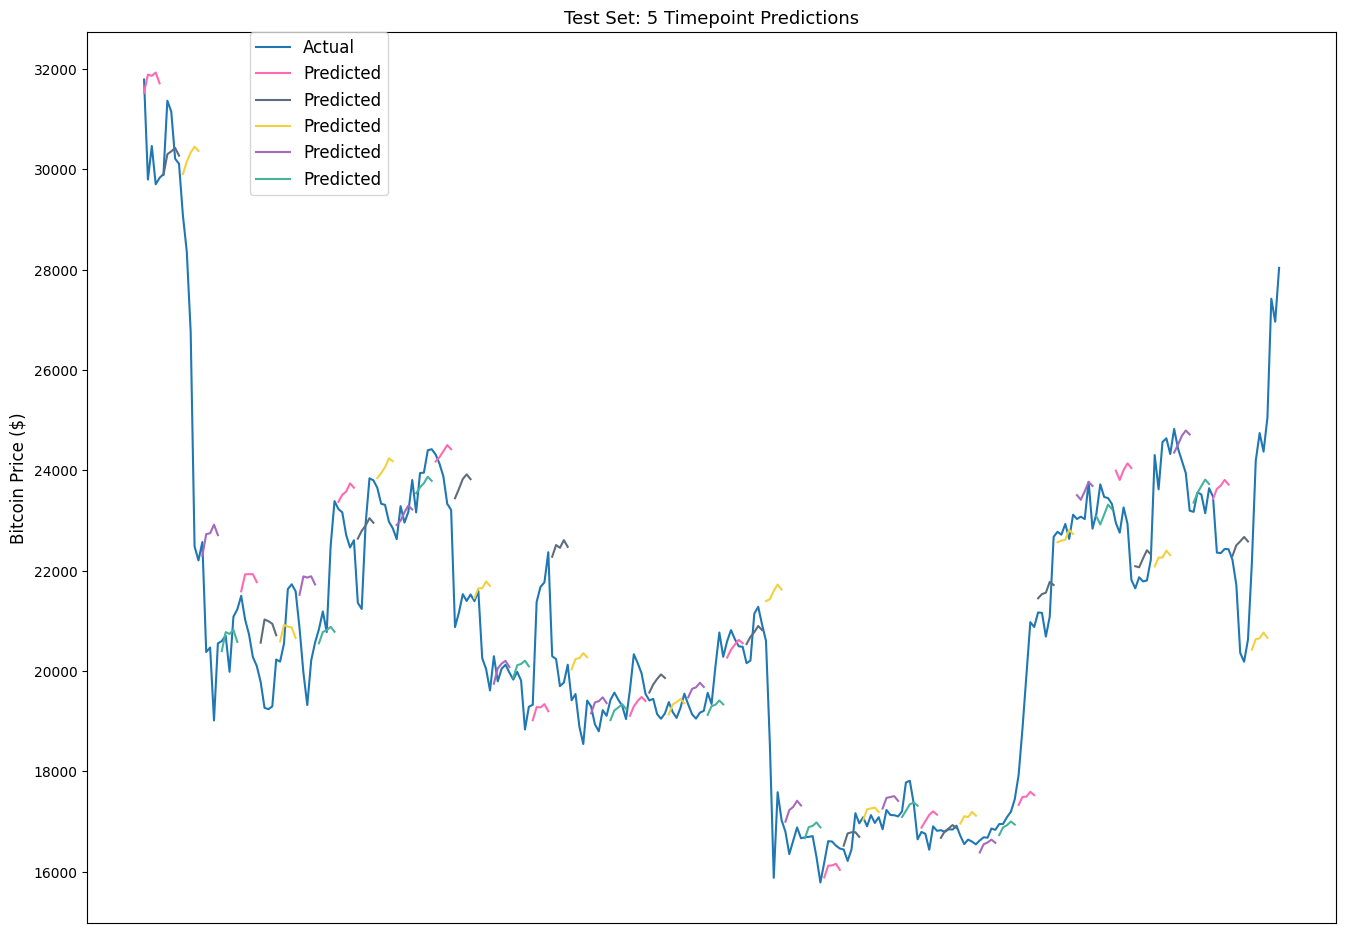

In [68]:
# little bit of reformatting the predictions to closing prices
bt_pred_prices = ((bt_model_5_day.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['bt_Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, ax1 = plt.subplots()
# ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
# ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
# ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])

# Tạo danh sách các tháng từ năm 2022 cho đến hiện tại
start_date = datetime.date(2022, 1, 1)  # Ngày bắt đầu là ngày 1 tháng 1 năm 2022
end_date = datetime.date.today()  # Ngày hiện tại
months = []
while start_date <= end_date:
    months.append(start_date)
    start_date = start_date.replace(day=1) + datetime.timedelta(days=32)
    start_date = start_date.replace(day=1)
# # Đặt các tick mark trên trục x
ax1.set_xticks([month for month in months])
ax1.set_xticklabels([month.strftime('%b %Y') for month in months])

ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:],
         test_set['bt_Close'][window_len:], label='Actual')

for i, bt_pred in enumerate(bt_pred_prices):
    # Only adding lines to the legend once
    if i<5:
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:][i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:][i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5])

ax1.set_title('Test Set: 5 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
fig.tight_layout()
fig.set_size_inches(15, 10)
plt.show()

Dự đoán 10 ngày 

In [69]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 10
# initialise model architecture
bt_model_10_day = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_Close'][i:i+pred_range].values/
                                  training_set['bt_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model_10_day.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
738/738 - 5s - loss: 0.1215 - 5s/epoch - 6ms/step
Epoch 2/50
738/738 - 6s - loss: 0.0921 - 6s/epoch - 8ms/step
Epoch 3/50
738/738 - 5s - loss: 0.0873 - 5s/epoch - 7ms/step
Epoch 4/50
738/738 - 4s - loss: 0.0833 - 4s/epoch - 6ms/step
Epoch 5/50
738/738 - 4s - loss: 0.0809 - 4s/epoch - 5ms/step
Epoch 6/50
738/738 - 3s - loss: 0.0820 - 3s/epoch - 4ms/step
Epoch 7/50
738/738 - 4s - loss: 0.0799 - 4s/epoch - 5ms/step
Epoch 8/50
738/738 - 3s - loss: 0.0800 - 3s/epoch - 4ms/step
Epoch 9/50
738/738 - 3s - loss: 0.0796 - 3s/epoch - 4ms/step
Epoch 10/50
738/738 - 3s - loss: 0.0791 - 3s/epoch - 5ms/step
Epoch 11/50
738/738 - 3s - loss: 0.0781 - 3s/epoch - 4ms/step
Epoch 12/50
738/738 - 3s - loss: 0.0779 - 3s/epoch - 4ms/step
Epoch 13/50
738/738 - 3s - loss: 0.0786 - 3s/epoch - 4ms/step
Epoch 14/50
738/738 - 3s - loss: 0.0778 - 3s/epoch - 4ms/step
Epoch 15/50
738/738 - 3s - loss: 0.0780 - 3s/epoch - 5ms/step
Epoch 16/50
738/738 - 3s - loss: 0.0767 - 3s/epoch - 4ms/step
Epoch 17/50
738/7

In [70]:
result_10_day = bt_model_10_day(LSTM_test_inputs[:-pred_range])
result_10_day

<tf.Tensor: shape=(283, 10), dtype=float32, numpy=
array([[-0.15416567, -0.1425103 , -0.14830795, ..., -0.14238325,
        -0.14340049, -0.14204746],
       [-0.14527349, -0.13288656, -0.1391462 , ..., -0.13558263,
        -0.1354752 , -0.13456962],
       [-0.17000341, -0.15832931, -0.16444845, ..., -0.15970266,
        -0.16443923, -0.16052608],
       ...,
       [-0.02129506, -0.00866774, -0.01727344, ..., -0.02304114,
        -0.02182485, -0.02558615],
       [-0.01701938, -0.00440372, -0.01283743, ..., -0.01813036,
        -0.01677355, -0.02051614],
       [-0.05333458, -0.04155445, -0.05082229, ..., -0.06108854,
        -0.06294367, -0.06597176]], dtype=float32)>

In [71]:
len(result_10_day)

283

In [72]:
# đưa kết quả dự đoán về giá trị ban đầu của Bitcoin
predicted_prices_denormalized = []
for i in range(len(result_10_day)):
    denormalized_price = (result_10_day[i]+1) * test_set['bt_Close'].values[i] 
    predicted_prices_denormalized.append(denormalized_price)
predicted_prices_10 = np.array(predicted_prices_denormalized)
predicted_prices_10

array([[32538.48 , 32986.85 , 32763.822, ..., 32991.742, 32952.605,
        33004.656],
       [32932.04 , 33409.3  , 33168.117, ..., 33305.42 , 33309.56 ,
        33344.45 ],
       [31332.748, 31773.45 , 31542.45 , ..., 31721.605, 31542.799,
        31690.52 ],
       ...,
       [22466.824, 22756.691, 22559.143, ..., 22426.742, 22454.662,
        22368.32 ],
       [22372.746, 22659.88 , 22467.928, ..., 22347.46 , 22378.342,
        22293.16 ],
       [22023.5  , 22297.557, 22081.947, ..., 21843.11 , 21799.951,
        21729.506]], dtype=float32)

In [73]:
LSTM_testing_outputs_10_day = []
for i in range(window_len, len(test_set['bt_Close'])-pred_range):
    LSTM_testing_outputs_10_day.append(test_set['bt_Close'][i:i+pred_range].values)
LSTM_testing_outputs_10_day = np.array(LSTM_testing_outputs_10_day)
LSTM_testing_outputs_10_day

array([[31792.310547, 29799.080078, 30467.488281, ..., 31155.478516,
        30214.355469, 30111.998047],
       [29799.080078, 30467.488281, 29704.390625, ..., 30214.355469,
        30111.998047, 29083.804688],
       [30467.488281, 29704.390625, 29832.914063, ..., 30111.998047,
        29083.804688, 28360.810547],
       ...,
       [22219.769531, 21718.080078, 20363.021484, ..., 24746.074219,
        24375.960938, 25052.789063],
       [21718.080078, 20363.021484, 20187.244141, ..., 24375.960938,
        25052.789063, 27423.929688],
       [20363.021484, 20187.244141, 20632.410156, ..., 25052.789063,
        27423.929688, 26965.878906]])

Dự đoán 20 ngày

In [74]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 20
# initialise model architecture
bt_model_20_day = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_Close'][i:i+pred_range].values/
                                  training_set['bt_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model_20_day.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                        epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
728/728 - 4s - loss: 0.1410 - 4s/epoch - 6ms/step
Epoch 2/50
728/728 - 3s - loss: 0.1179 - 3s/epoch - 5ms/step
Epoch 3/50
728/728 - 3s - loss: 0.1152 - 3s/epoch - 4ms/step
Epoch 4/50
728/728 - 4s - loss: 0.1133 - 4s/epoch - 5ms/step
Epoch 5/50
728/728 - 4s - loss: 0.1088 - 4s/epoch - 5ms/step
Epoch 6/50
728/728 - 3s - loss: 0.1113 - 3s/epoch - 5ms/step
Epoch 7/50
728/728 - 3s - loss: 0.1082 - 3s/epoch - 5ms/step
Epoch 8/50
728/728 - 4s - loss: 0.1087 - 4s/epoch - 5ms/step
Epoch 9/50
728/728 - 4s - loss: 0.1058 - 4s/epoch - 5ms/step
Epoch 10/50
728/728 - 4s - loss: 0.1052 - 4s/epoch - 5ms/step
Epoch 11/50
728/728 - 3s - loss: 0.1035 - 3s/epoch - 4ms/step
Epoch 12/50
728/728 - 3s - loss: 0.1069 - 3s/epoch - 4ms/step
Epoch 13/50
728/728 - 4s - loss: 0.1043 - 4s/epoch - 5ms/step
Epoch 14/50
728/728 - 3s - loss: 0.1047 - 3s/epoch - 5ms/step
Epoch 15/50
728/728 - 3s - loss: 0.1000 - 3s/epoch - 4ms/step
Epoch 16/50
728/728 - 3s - loss: 0.1045 - 3s/epoch - 4ms/step
Epoch 17/50
728/7

In [75]:
result_20_day = bt_model_20_day(LSTM_test_inputs[:-pred_range])
result_20_day

<tf.Tensor: shape=(273, 20), dtype=float32, numpy=
array([[-0.1568526 , -0.16683534, -0.17747326, ..., -0.13968983,
        -0.14811762, -0.14577685],
       [-0.15511927, -0.16586286, -0.17406864, ..., -0.1545701 ,
        -0.16281019, -0.16101365],
       [-0.18868461, -0.19978872, -0.20358913, ..., -0.1718589 ,
        -0.18100123, -0.18221353],
       ...,
       [ 0.02446372,  0.02006408,  0.01873107, ..., -0.01387188,
        -0.01717784, -0.01863229],
       [ 0.01315364,  0.00738134, -0.00131427, ..., -0.0341851 ,
        -0.03889798, -0.04359129],
       [ 0.00123852, -0.01535086, -0.02929516, ..., -0.08720511,
        -0.09030311, -0.09435682]], dtype=float32)>

In [76]:
# đưa kết quả dự đoán về giá trị ban đầu của Bitcoin
predicted_prices_denormalized = []
for i in range(len(result_20_day)):
    denormalized_price = (result_20_day[i]+1) * test_set['bt_Close'].values[i] 
    predicted_prices_denormalized.append(denormalized_price)
predicted_prices_20 = np.array(predicted_prices_denormalized)
predicted_prices_20

array([[32435.117, 32051.09 , 31641.86 , ..., 33095.355, 32771.145,
        32861.19 ],
       [32552.686, 32138.744, 31822.58 , ..., 32573.846, 32256.36 ,
        32325.58 ],
       [30627.525, 30208.34 , 30064.871, ..., 31262.701, 30917.574,
        30871.809],
       ...,
       [23596.246, 23494.91 , 23464.207, ..., 22713.27 , 22637.125,
        22603.623],
       [23382.299, 23249.08 , 23048.396, ..., 22289.78 , 22181.012,
        22072.697],
       [23059.613, 22677.543, 22356.39 , ..., 21022.66 , 20951.31 ,
        20857.95 ]], dtype=float32)

In [77]:
LSTM_testing_outputs_20_day = []
for i in range(window_len, len(test_set['bt_Close'])-pred_range):
    LSTM_testing_outputs_20_day.append(test_set['bt_Close'][i:i+pred_range].values)
LSTM_testing_outputs_20_day = np.array(LSTM_testing_outputs_20_day)
LSTM_testing_outputs_20_day

array([[31792.310547, 29799.080078, 30467.488281, ..., 20471.482422,
        19017.642578, 20553.271484],
       [29799.080078, 30467.488281, 29704.390625, ..., 19017.642578,
        20553.271484, 20599.537109],
       [30467.488281, 29704.390625, 29832.914063, ..., 20553.271484,
        20599.537109, 20710.597656],
       ...,
       [23175.375   , 23561.212891, 23522.871094, ..., 24746.074219,
        24375.960938, 25052.789063],
       [23561.212891, 23522.871094, 23147.353516, ..., 24375.960938,
        25052.789063, 27423.929688],
       [23522.871094, 23147.353516, 23646.550781, ..., 25052.789063,
        27423.929688, 26965.878906]])

In [78]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# # Định nghĩa hàm tính RMSE
# def rmse(y_true, y_pred):
#     return math.sqrt(mean_squared_error(y_true, y_pred))

# Định nghĩa hàm đánh giá mô hình
def evaluate(model, X_test, y_test):
    # Dự đoán giá trị
    y_pred = model.predict(X_test)
    rmse=0

    # Tính toán các chỉ số đánh giá
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Trả về các chỉ số đánh giá
    return mae, mse, rmse, r2

# Đánh giá mô hình
mae, mse, rmse, r2 = evaluate(bt_model, LSTM_test_inputs, LSTM_test_outputs)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)


10/10 [==============================] - 0s 3ms/step
MAE: 0.02545118117446546
MSE: 0.0012611525114903453
RMSE: 0.03551270915447518
R2 Score: 0.9588707692076144


Evaluate model

In [79]:
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error


def evaluate_forecast_results(actual, predicted):
    print('R2 Score: ', round(r2_score(actual, predicted), 2))
    print('MAE : ', round(mae(actual, predicted), 2))
    print('MSE: ', round(mean_squared_error(actual, predicted), 2))
    print('RMSE: ', round(math.sqrt(mean_squared_error(actual, predicted)), 2))
    print('NRMSE: ', NRMSE(actual, predicted))
    print('WMAPE: ', WMAPE(actual, predicted))


def NRMSE(actual, predicted):
    rmse = math.sqrt(mean_squared_error(actual, predicted))
    nrmse = rmse / (actual.max() - actual.min())
    return round(nrmse, 4)


def WMAPE(actual, forecast):
    abs_error = np.sum(abs(actual - forecast))
    wmape = abs_error / np.sum(actual)
    return round(wmape, 4)

In [80]:
evaluate_forecast_results( test_set['bt_Close'][window_len:], ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_Close'].values[:-window_len])[0])

10/10 [==============================] - 0s 3ms/step
R2 Score:  0.93
MAE :  567.45
MSE:  687200.72
RMSE:  828.98
NRMSE:  0.0518
WMAPE:  0.0272


In [81]:
evaluate_forecast_results(LSTM_testing_outputs_5_day,predicted_prices_5)

R2 Score:  0.78
MAE :  881.02
MSE:  1967622.58
RMSE:  1402.72
NRMSE:  0.0876
WMAPE:  0.0425


In [82]:
evaluate_forecast_results(LSTM_testing_outputs_10_day,predicted_prices_10)

R2 Score:  0.54
MAE :  1212.93
MSE:  3635068.63
RMSE:  1906.59
NRMSE:  0.1191
WMAPE:  0.0589


In [83]:
evaluate_forecast_results(LSTM_testing_outputs_20_day,predicted_prices_20)

R2 Score:  0.06
MAE :  1620.05
MSE:  6101518.52
RMSE:  2470.13
NRMSE:  0.1543
WMAPE:  0.0793


Lưu trữ model

In [84]:
import pickle
from keras.models import load_model

# Lưu trữ mô hình vào file
bt_model.save('lstm_model.h5')

# Đóng gói mô hình và lưu trữ vào file
with open('lstm_model.pkl', 'wb') as f:
    pickle.dump(bt_model, f)

# Tải mô hình đã được đóng gói
with open('lstm_model.pkl', 'rb') as f:
    model = pickle.load(f)

# # Dự đoán với tập dữ liệu mới
# new_data = ...
# predictions = model.predict(new_data)


In [85]:
import pickle
from keras.models import load_model

# Lưu trữ mô hình vào file
bt_model_5_day.save('lstm_model_5_day.h5')

# Đóng gói mô hình và lưu trữ vào file
with open('lstm_model_5_day.pkl', 'wb') as f:
    pickle.dump(bt_model_5_day, f)

# Tải mô hình đã được đóng gói
with open('lstm_model_5_day.pkl', 'rb') as f:
    model_5_day = pickle.load(f)

# # Dự đoán với tập dữ liệu mới
# new_data = ...
# predictions = model.predict(new_data)